<a href="https://colab.research.google.com/github/csabot3/liverAItutorial/blob/main/Lesson4_Part1_Neural_Networks_Revisited_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 4, Part 1: Neural Networks Revisited

In lesson 2, we emphasized practical implementation of U-nets for segmentation of liver CT and MRI data but we did not deeply explore some of the fundamental aspects involved with training and understanding neural network models. 

In this lesson, which is divided into multiple parts, we will re-examine neural network training with FastAI. We will again use the CHAOS dataset but instead of focusing on organ segmentation, we will instead investigate classification. We will place additional emphasis this time on details such as our choice of neural network model architecture, the learning rate, the loss function, the optimizer, and image augmentations.

In [1]:
#Import libraries/packages

!pip install pydicom #Not in Colab by default
!apt-get -qq install pv #Progress bar, also not in Colab

#Now we will import several parts of the FastAI library

!pip install fastai --upgrade -q

from IPython.display import display,HTML

from fastai.vision.all import *
from fastcore.xtras import Path
from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

import os
import shutil
import pydicom
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import numpy as np
from pathlib import Path
import pandas as pd
import glob
import sys

     |████████████████████████████████| 2.0 MB 16.0 MB/s 
Selecting previously unselected package pv.
(Reading database ... 155455 files and directories currently installed.)
Preparing to unpack .../archives/pv_1.6.6-1_amd64.deb ...
Unpacking pv (1.6.6-1) ...
Setting up pv (1.6.6-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 188 kB 34.3 MB/s 
     |████████████████████████████████| 60 kB 8.8 MB/s 


In [2]:
#Check the GPU - we need a GPU runtime

!nvidia-smi

Thu Apr 14 23:23:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#Get the CHAOS dataset and unzip it

!wget -q --show-progress https://zenodo.org/record/3431873/files/CHAOS_Train_Sets.zip?download=1

!unzip -q  CHAOS_Train_Sets.zip\?download\=1

CHAOS_Train_Sets.zi 100%[===================>] 849.51M  6.43MB/s    in 2m 23s  


In [4]:
#Make new folders, similar to lesson 2
if not os.path.exists('./images'):
  os.mkdir('./images')
if not os.path.exists('./labels'):  
  os.mkdir('./labels')

So far, we are basically just recreating steps from lesson 2, but now when we reformat the dataset, we will also create a label of whether or not the axial slice contains the liver at all for the CT data

In [5]:
#New folders for liver presence/absence classification

#We will create dedicated training and validation data folders this time
#The structure will be such that the grandparent folder name is train or valid
#and the parent folder name is the class liver versus noliver in our scenario

if not os.path.exists('./liverClass/train/liver'):
  os.makedirs('./liverClass/train/liver',exist_ok=True) #This alternative to os.mkdir, os.makedirs
  #will let us also make the parent folders when we make the class folders
if not os.path.exists('./liverClass/train/notliver'):
  os.makedirs('./liverClass/train/notliver',exist_ok=True)
if not os.path.exists('./liverClass/valid/liver'):
  os.makedirs('./liverClass/valid/liver',exist_ok=True)
if not os.path.exists('./liverClass/valid/notliver'):
  os.makedirs('./liverClass/valid/notliver',exist_ok=True)



#We will also explicitly split the patient list into the training and validation datasets
valcasepicks=['1','2','5','6']


In [6]:
#Rearrange and reformat the dataset, once again
labelpathct=Path('./Train_Sets/CT')
trainls=os.listdir(labelpathct)

#Track slices that contain liver
runls=[]
liverlabels=[]
liveronlynames=[]
livernotnames=[]


for f1 in trainls:
  dcls=sorted(os.listdir(labelpathct/f1/'DICOM_anon'))
  labls=sorted(os.listdir(labelpathct/f1/'Ground'))
  for x1 in range(0,len(dcls)):
    dcpick=labelpathct/f1/'DICOM_anon'/dcls[x1]
    labpick=labelpathct/f1/'Ground'/labls[x1]
    savestem=labls[x1].split('.')[0] #Split the name from the suffix
    savenamekeep=str(f1)+'-'+savestem+'.tif'
    ctex=pydicom.dcmread(dcpick) #Load the DICOM
    huimg=pydicom.pixel_data_handlers.util.apply_modality_lut(ctex.pixel_array,ctex) #Convert to HU

    Image.fromarray(huimg).save('./images/'+savenamekeep) #Save the DICOM image data as a TIF

    #Open the existing label image and save it in a modified format
    imtemp=np.array(Image.open(labpick))
    Image.fromarray(imtemp.astype('uint8')).convert('L').save('./labels/'+str(f1)+'-'+savestem+'.png')

    if np.sum(imtemp)>0:
      liveronlynames.append(savenamekeep)
      liverlabels.append(1)
      #Now we can copy the image to the appropriate folder
      if f1 in valcasepicks: #Check for validation set based on the case selections
        #Use shuti.copy(source, dest) to copy image to classification folder scheme
        shutil.copy('./images/'+savenamekeep,'./liverClass/valid/liver/'+savenamekeep)
      else:
        #Training data
        shutil.copy('./images/'+savenamekeep,'./liverClass/train/liver/'+savenamekeep)
    else:
      liverlabels.append(0)
      livernotnames.append(savenamekeep)
      if f1 in valcasepicks: #Check for validation set based on the case selections
        #Use shuti.copy(source, dest) to copy image to classification folder scheme
        shutil.copy('./images/'+savenamekeep,'./liverClass/valid/notliver/'+savenamekeep)
      else:
        #Training data
        shutil.copy('./images/'+savenamekeep,'./liverClass/train/notliver/'+savenamekeep)

With our data and folder organization set up now similar to ImageNet folder organization, we can move on to setting up the datablock for creating a binary classifier for whether or not an axial CT slice contains liver

Since we are diving a bit deeper now, we will focus specifically on image augmentation/transformation for our dataset. Now, if we are doing a segmentation task, then we need to be careful that our image transformation/augmentation performed on our input image data also matches with a correlated transform of the segmentation label image.

For our classification task, we will now define some custom transforms

In [7]:
imgszpick=320

custom_imgtfms=[DihedralItem(),#Dihedral transformation in 1 of 8 randomly selected configurations
                Resize(imgszpick)]


In Lesson 2, we still used image augmentation, but we used the FastAI function aug_transforms which utilized several default FastAI image augmentation transforms which we did not explicitly enumerate in that lesson.

The default aug_transforms image augmentations can be read about in the FastAI documentation: https://docs.fast.ai/vision.augment.html#aug_transforms

In this lesson, we will more explicitly manipulate aug_transforms and modify several of the inputs. We will also do transformations at the item level and the batch level where previously in lesson 2 we only did batch level transformations. In this example, we are doing dihedral transforms and resizing at the item level and based on our modification of the default transforms included in aug_transforms, at the batch level we are doing random rotations, zooms, lighting adjustments, and image warping.

In [8]:
datablock1=DataBlock(blocks=(ImageBlock,CategoryBlock),
                     get_items=get_image_files,
                     get_y=parent_label, #Build in FastAI function for labeling classes based on the parent folder (appropriate for our setup
                     splitter=GrandparentSplitter(train_name='train', valid_name='valid'), #A FastAI function also convenient based on the file arrangement that we have used in this scenario
                     item_tfms=custom_imgtfms,
                     batch_tfms=[*aug_transforms(do_flip=False,max_rotate=5.0,max_zoom=1.05,
                                                 max_lighting=0.05,max_warp=0.05),Normalize.from_stats(*imagenet_stats)]
                )
    



Also, now we should have a discussion about image size and its relationship with batch size. Our axial slices for CT are 512x512 pixels. This size is feasible to run at full resolution with a reasonable batch size of, perhaps 8, while still not exceeding the RAM of the GPU. We can look at the data about our GPU by inspecting the output of !nvidia-smi which we executed in a cell at the start of this notebook. With a 16 GB RAM on a Tesla P100 GPU, we don't have to worry too much about image size as a constraint for 2D CT and MRI data. However, if we tried to model full resolution radiographs with greater than 1000 pixels in each dimension, then this would potentially be a problem. With an image size of 320x320 and a batch size of 16, we won't have an issue with exceeding the RAM of GPUs accessible in Colab, but this is an important consideration depending on possible hardware considerations.

Batch size and image size are also important consideration for training time to run each epoch of training

In [9]:
#Now let's but the data block into a data loader
dls=datablock1.dataloaders('./liverClass',bs=8,path='.') 

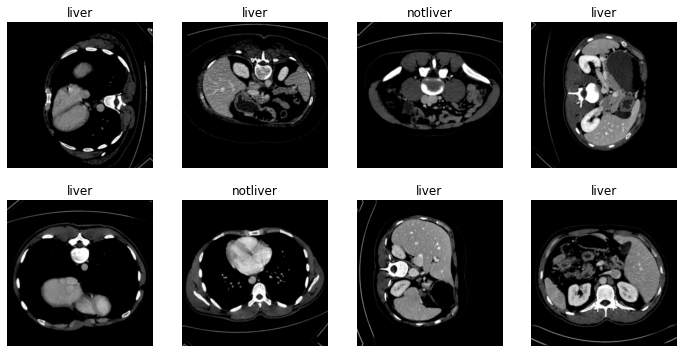

In [10]:
dls.show_batch() #Look at the inputs

In [11]:
#Let's set up our learner
learn = cnn_learner(dls, resnet34, metrics=[accuracy], pretrained=True, opt_func=Adam)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [12]:
learn.loss_func #Look at the default loss function (flattend cross entropy loss)

FlattenedLoss of CrossEntropyLoss()

Now previously in lesson 2, we did not discuss the process of how to select a learning rate for our model. The learning rate is essentially a hyperparameter which determines how big of a change the model tries to make to its weights at each step while it optimizes with respect to the loss function.

In FastAI, we can use a learning rate finder feature based on the work of Leslie Smith: https://arxiv.org/abs/1803.09820

Let's take a look at the learning rate finder

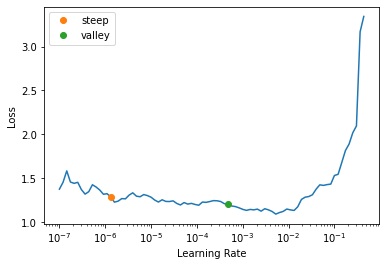

In [13]:
lrf=learn.lr_find(suggest_funcs=(steep,valley))

Based on this curve, there are a few different methods to pick the best learning rate. Conveniently, FastAI will suggest different options, and the valley approach often seems reasonable (and is currently the default suggestion). You can learn more about the details of this learning rate selection process based on an excellent blog post from one of the FastAI developers, Sylvain Gugger:

https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

or based on these FastAI forum threads: https://forums.fast.ai/t/automated-learning-rate-suggester/44199/30

https://forums.fast.ai/t/new-lr-finder-output/89236/3

In [14]:
lrf.valley

0.0004786300996784121

In [15]:
lr1 = 5e-3 #Based on our learning rate finder curve analysis, we will use 0.005 as the initial learning rate

learn.fit_one_cycle(20,slice(lr1))

epoch,train_loss,valid_loss,accuracy,time
0,0.555531,0.648250,0.708333,00:39
1,0.435368,0.182359,0.950000,00:36
2,0.381304,0.119108,0.961111,00:35
3,0.386712,0.164706,0.930556,00:35
4,0.304385,0.308939,0.869444,00:36
5,0.334861,0.075922,0.961111,00:35
6,0.178771,0.139860,0.955556,00:36
7,0.211692,0.118877,0.938889,00:35
8,0.156397,0.110685,0.944444,00:36
9,0.144104,0.143868,0.941667,00:36


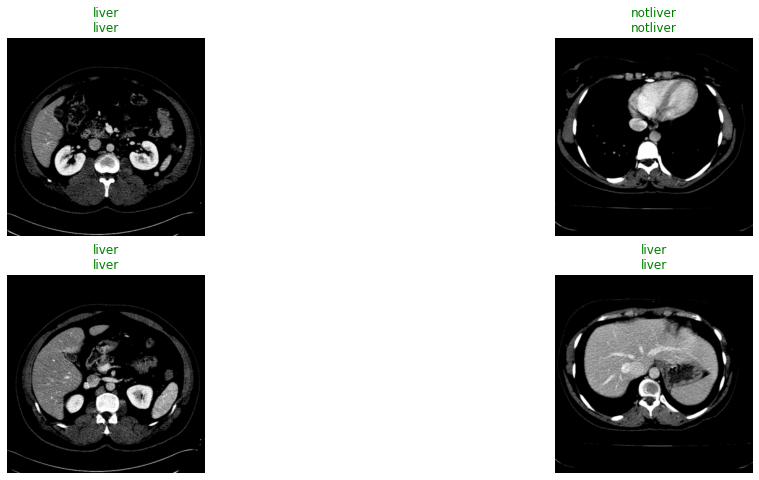

In [16]:
learn.show_results(max_n=4, figsize=(18,8))

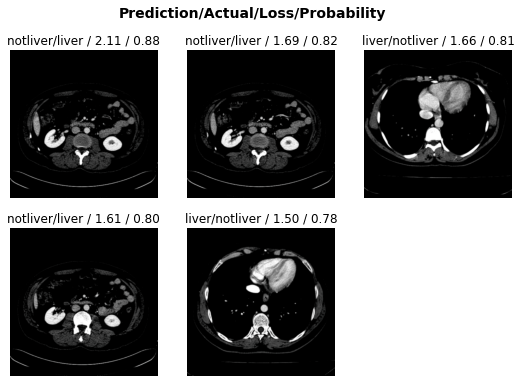

In [17]:
#Use the FastAI interpretation class
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(5)

In [18]:
learn.save('res34-20epochs-lr5e-3')

Path('models/res34-20epochs-lr5e-3.pth')

Now for the next part, for illustrative purposes, we will restart the training process from the ImageNet pretrained models that we are using for model initialization and then pick very suboptimal learning rates that are either much too low for the training process to be efficient (0.0000001) or too high so that the optimization is unstable/erratic as it tries to find a minimum for the loss function (0.1). If you already feel comfortable with the concept of learning rate, then feel free to skip these steps as they are specifically illustrative of bad versions of model training

In [19]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy], pretrained=True, opt_func=Adam)
learn.fit_one_cycle(10,slice(1e-7))

epoch,train_loss,valid_loss,accuracy,time
0,1.430543,0.884963,0.530556,00:36
1,1.487367,0.858053,0.558333,00:35
2,1.530552,1.000888,0.477778,00:36
3,1.443386,0.852711,0.550000,00:36
4,1.481984,0.848513,0.530556,00:35
5,1.416134,0.981767,0.513889,00:35
6,1.446262,0.932348,0.519444,00:36
7,1.397886,0.745975,0.627778,00:36
8,1.371097,0.910892,0.527778,00:35
9,1.473370,0.801198,0.588889,00:35


With our learning rate much too low, 10 epochs does not get us very far at all in the optimization process. It would take us a very long time to train a model like this. 

In [20]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy], pretrained=True, opt_func=Adam)
learn.fit_one_cycle(10,slice(0.1))

epoch,train_loss,valid_loss,accuracy,time
0,1.320991,0.228448,0.933333,00:36
1,4.321865,0.503266,0.925000,00:35
2,7.782893,3.437342,0.872222,00:35
3,2.415251,79.908997,0.797222,00:35
4,2.562800,19.883183,0.847222,00:35
5,1.198418,13.855482,0.652778,00:35
6,0.565919,2.132581,0.966667,00:35
7,0.324516,0.090293,0.961111,00:35
8,0.244020,0.087240,0.969444,00:35
9,0.160284,0.092847,0.969444,00:35


With our learning rate too high, we still get some versions of the model with good performance at different epochs but we also have very erratic validation loss which is disparate from the training loss. This type of erratic performance between epochs would obviously be quite concerning from a model generalizabity perspective. 

We don't need to pick a perfect learning rate, though, we just need one that is good enough. We essentially have a "goldilocks zone" situation where we just don't want one too big or too small, but can benefit from a bigger learning rate in that the model will train faster.

Let's try some training one more time with 0.001 as our learning rate. 

In [21]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy], pretrained=True, opt_func=Adam)
learn.fit_one_cycle(10,slice(0.001))

epoch,train_loss,valid_loss,accuracy,time
0,0.752583,0.342932,0.836111,00:35
1,0.438134,0.140807,0.955556,00:35
2,0.371614,0.119952,0.950000,00:35
3,0.181797,0.208351,0.916667,00:35
4,0.297800,0.126907,0.958333,00:35
5,0.175990,0.195096,0.927778,00:35
6,0.181853,0.122781,0.941667,00:35
7,0.138926,0.226865,0.922222,00:35
8,0.166109,0.142613,0.941667,00:35
9,0.132817,0.135850,0.944444,00:35


This learning rate works pretty well as we can see, so while we want to pick a learning rate in an appropriate range, we don't need a perfect learning rate

On the topic of learning rates, we should probably also call attention to the fact that in FastAI the fit_one_cycle method that we are calling is not as straightforward as other methods for training a model and we are doing cosine annealing of the learning rate as part of the training process. Overall, this follows the 1 cycle policy for training the model which is based on the work of Leslie Smith: https://arxiv.org/abs/1708.07120

We would also recommend the FastAI documentation for more information about the details of this:

https://docs.fast.ai/callback.schedule.html#Learner.fit_one_cycle

Next we will look at changing the optimizer. The default optimizer in FastAI, Adam is usually not something we need to change or worry about. But, for illustrative purposes, we will change it to stochastic gradient descent (SGD) which is a more historic optimizer approach compared to Adam and known to underperform it. 

You can read more about Adam in this paper: https://arxiv.org/abs/1412.6980


In [22]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy], pretrained=True, opt_func=SGD)
learn.fit_one_cycle(10,slice(0.001))

epoch,train_loss,valid_loss,accuracy,time
0,1.130047,0.720560,0.650000,00:35
1,0.895268,0.592120,0.719444,00:35
2,0.690976,0.597647,0.727778,00:35
3,0.585402,0.541905,0.744444,00:35
4,0.566867,0.499434,0.755556,00:35
5,0.549421,0.515504,0.763889,00:35
6,0.452172,0.435623,0.797222,00:35
7,0.483680,0.403468,0.811111,00:35
8,0.527183,0.460188,0.788889,00:35
9,0.501556,0.383007,0.816667,00:35


We can see that SGD is not working quite as well as Adam did in the previous example. If you are interested, consider increasing the number of epochs.

Alternatively consider exploring other optimizers available in FastAI:

https://docs.fast.ai/optimizer.html

However, again, in a practical approach, Adam is usually sufficient as an optimizer in our experience working with radiology applications.

Next, let's look a little more closely at the loss function. We have been using cross entropy as our loss function which is a standard loss function in neural network training for classification problems. However, we have not been adjusting the cross entropy loss function weights even though our classes in this scenario are imbalanced. Let's take a look at this for the combined training and validation set using the labels we generated earlier

In [23]:
np.sum(liverlabels) #Number of slices containing liver

2341

In [24]:
len(liverlabels) #Number of total slices

2874

In [25]:
100*np.sum(liverlabels)/len(liverlabels) #So 81% of this dataset has the liver label compared to 19% without

81.4544189283229

Given this class imbalance, we might want to adjust the class weights in our loss function

In [26]:
learn.dls.vocab #Check on our classes

['liver', 'notliver']

In [27]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy], pretrained=True,
                    opt_func=Adam, loss_func=CrossEntropyLossFlat(weight=torch.tensor([0.25,1.0])))


Now, we have used cnn_learner with a specified loss function which is the same as the default except we have added a tensor of weights.

Let's check our learning rate finder curve again

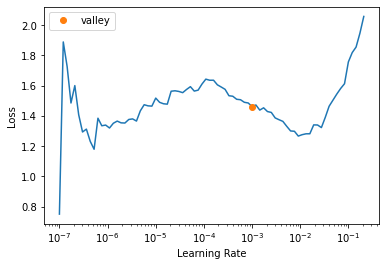

In [28]:
lrf=learn.lr_find(suggest_funcs=(valley))

In [29]:
lrf.valley

0.0010000000474974513

In [30]:
learn.fit_one_cycle(10,slice(0.005))

epoch,train_loss,valid_loss,accuracy,time
0,0.646004,1.168976,0.666667,00:35
1,0.602670,0.495414,0.802778,00:35
2,0.451513,0.577648,0.822222,00:35
3,0.359058,0.246970,0.930556,00:36
4,0.379273,0.473951,0.883333,00:35
5,0.264220,0.244216,0.900000,00:35
6,0.160873,0.374693,0.875000,00:35
7,0.152905,0.196575,0.911111,00:35
8,0.133752,0.224831,0.905556,00:35
9,0.132868,0.158989,0.927778,00:35


The last aspect of our convolutional neural network model that we will look at in this part is the neural network architecture. So far we have been training with ResNet34, but now let's look at some different ResNets (ResNet18 and ResNet50) which have different depths/number of layers compared to ResNet34

In [31]:
learn = cnn_learner(dls, resnet18, metrics=[accuracy], pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [32]:
learn.summary() #We can use this to inspect the architecture in more depth

Sequential (Input shape: 8 x 3 x 320 x 320)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 160 x 160  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 80 x 80    
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                       

This also a good place to talk more about the concept of training only a portion of the model. If we look in the model summary, we have over 11 million total parameters in this model. We are training a lot of them right now (almost half a million) but we are also not training 11 million of the parameters that we could be training. We have used a model pre-trained on ImageNet and we are not training the backbone of the model right now because we are presuming that the network parameters for the early layers of our model which were effective on ImageNet will also be useful for our current classification task. Consequently, we are focusing on training the final layers of the model.

In [33]:
learn.fit_one_cycle(10,slice(0.001))

epoch,train_loss,valid_loss,accuracy,time
0,0.712090,0.946098,0.580556,00:28
1,0.396610,0.379251,0.830556,00:29
2,0.294906,0.384715,0.836111,00:29
3,0.320037,0.157085,0.936111,00:29
4,0.246484,0.162374,0.933333,00:28
5,0.221118,0.216088,0.913889,00:29
6,0.184163,0.204901,0.908333,00:29
7,0.158869,0.160769,0.925000,00:29
8,0.194778,0.216562,0.911111,00:28
9,0.150239,0.197268,0.913889,00:29


Now to look at ResNet50, a deeper version of the ResNet architecture

In [34]:
learn = cnn_learner(dls, resnet50, metrics=[accuracy], pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [35]:
learn.summary()

Sequential (Input shape: 8 x 3 x 320 x 320)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 160 x 160  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 80 x 80    
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     8 x 256 x 80 x 80   
Conv2d                                    16384      False     
BatchNorm2d                         

Again, the backbone of the model is frozen, so we are only training about 2 million parameters instead of the more than 25 million possible paramters. 

In [36]:
learn.fit_one_cycle(10,slice(0.001))

epoch,train_loss,valid_loss,accuracy,time
0,0.761679,0.377895,0.836111,00:59
1,0.454088,0.595084,0.772222,00:57
2,0.304167,0.311775,0.877778,00:58
3,0.249794,0.127629,0.958333,00:58
4,0.151435,0.120721,0.944444,00:58
5,0.184356,0.174043,0.916667,00:58
6,0.173947,0.112050,0.955556,00:58
7,0.125289,0.123285,0.952778,00:58
8,0.111711,0.128008,0.947222,00:58
9,0.128587,0.135810,0.941667,00:58


Now let's look at what training the ResNet50 unfrozen looks like

In [37]:
learn.unfreeze() #Unfreeze the backbone model parameters

In [38]:
learn.summary()

Sequential (Input shape: 8 x 3 x 320 x 320)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 160 x 160  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 80 x 80    
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     8 x 256 x 80 x 80   
Conv2d                                    16384      True      
BatchNorm2d                         

In [39]:
learn.fit_one_cycle(10,slice(0.001))

epoch,train_loss,valid_loss,accuracy,time
0,0.168888,0.380795,0.866667,01:15
1,0.169642,0.170051,0.925000,01:14
2,0.233457,0.423999,0.813889,01:14
3,0.174540,0.067127,0.980556,01:14
4,0.176919,0.211945,0.886111,01:14
5,0.148355,0.035244,0.986111,01:14
6,0.078041,0.037597,0.986111,01:14
7,0.043870,0.081918,0.963889,01:14
8,0.039374,0.018487,0.991667,01:14
9,0.037614,0.018455,0.997222,01:14


Clearly, unfreezing the backbone is helpful as now we have our best performance so far. 

Let's now briefly look at another popular architecture, DenseNet

In [40]:
learn = cnn_learner(dls, densenet121, metrics=[accuracy], pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [41]:
learn.summary()

Sequential (Input shape: 8 x 3 x 320 x 320)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 160 x 160  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 80 x 80    
MaxPool2d                                                      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 128 x 80 x 80   
Conv2d                                    8192       False     
BatchNorm2d                               256        True      
ReLU                                                           
____________________________________

In [42]:
learn.fit_one_cycle(10,slice(0.001)) #Train for a bit with a frozen backbone


epoch,train_loss,valid_loss,accuracy,time
0,0.670883,0.864475,0.588889,01:14
1,0.403741,0.075291,0.972222,01:13
2,0.267889,0.054284,0.980556,01:13
3,0.236605,0.058332,0.977778,01:13
4,0.182382,0.177988,0.927778,01:13
5,0.163503,0.056895,0.980556,01:14
6,0.113718,0.056510,0.983333,01:13
7,0.124033,0.060704,0.983333,01:13
8,0.096676,0.099098,0.966667,01:13
9,0.100568,0.089325,0.961111,01:13


In [43]:
learn.unfreeze()
learn.fit_one_cycle(10,slice(0.001)) #Train again unfrozen

epoch,train_loss,valid_loss,accuracy,time
0,0.117621,0.347868,0.863889,01:30
1,0.233825,0.090706,0.969444,01:29
2,0.142293,0.081799,0.963889,01:29
3,0.125347,0.040252,0.991667,01:29
4,0.111356,0.019605,0.997222,01:29
5,0.091127,0.036175,0.980556,01:29
6,0.060802,0.028296,0.994444,01:29
7,0.063778,0.020106,0.991667,01:29
8,0.029881,0.014813,0.994444,01:29
9,0.030627,0.013728,0.997222,01:29


Now, to summarize this lesson so far, we have made a much simpler model than in lesson 2 in that we have focused on a classification model that simply determines whether or not the liver is present within an axial CT slice and does not perform segmentation. We have used this simpler neural network scenario to dig a little deeper into the learning rate, the loss function, the optimizer and the neural network model architecture. Obviously, there is plenty of additional room for experimentation. For example, additional architectures readily usable with FastAI can be reviewed in the FastAI documentation:

https://fastai1.fast.ai/vision.models.html

In part 2 of this lesson, we will turn back to the MRI data and look at neural networks for classifying hepatic steatosis. Again, we will place an emphasis on some of the variety of options available for modeling. 